In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

### Figure 5 is based on several important BED-files ...

In [4]:
feat_names = OrderedDict()
feat_names["tss"] = "ActiveTSS-NO-CTCF-8849-1bp.bed"
feat_names["tts"] = "ActiveTTS-withoutH3K4-NO-CTCF-10933-1bp.bed"

## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [5]:
# bf is short for bioframe here ...
dfs = OrderedDict()
for k in feat_names:
    _df = bf.read_table(
        feat_names[k],
        names=["chrom","start","end","strand"],
        usecols=(0,1,2,3),
        index_col=None
    )
    _k = f"{k}p"
    dfs[_k] = _df[_df["strand"]=="+"]
    dfs[_k] = dfs[_k].sort_values(["chrom","start"])
    dfs[_k] = dfs[_k][dfs[_k]["chrom"].isin(autosomal_chroms)]
    dfs[_k] = dfs[_k].reset_index(drop=True)
    # negative
    _k = f"{k}m"
    dfs[_k] = _df[_df["strand"]=="-"]
    dfs[_k] = dfs[_k].sort_values(["chrom","start"])
    dfs[_k] = dfs[_k][dfs[_k]["chrom"].isin(autosomal_chroms)]
    dfs[_k] = dfs[_k].reset_index(drop=True)
# merge_radius = 500
# df_merged = bf.merge(df, min_dist=merge_radius)
# print(f"number of candidate features before and after merging: {len(df)} -> {len(df_merged)}")

### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


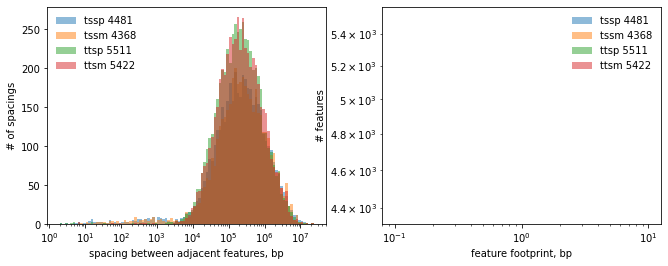

In [6]:
# just an overview of all of them together ...
plot_spacing_footprint_distros(dfs)

### in our analyses (insulation/compartments) we wouldn't resolve features that are too close ...
#### let's see what clustering those adjacent ones could do for us
#### let's try to pick a good clustering "radius" first - should be  around ~1-10kb ...

it's actually merging that we're doing - i.e. we don't need to know cluster information - just need to collapse nearby intervals into larger ones

to see how varying clustering radius affects the results see the gist : blah ...

### Not sure if we'd need to do it here, given the lare footprint of the G4 related peaks !!!...

### let's have the original CTCF and RAD21 peak calls here to do count them along our stackups as well...

### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [7]:
#let's describe our samples that we want to have in Figure 1 ...
fig5_samples = ["rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","ins_polII","ins_nopolII","ev1_CTCF","ev1_noCTCF","ev1_polII","ev1_nopolII","ddx_CTCF","ddx_noCTCF","taf5l_CTCF","taf5l_noCTCF","Rloop_K562","polII",'h3k4_r1',"mrna_ctcf","mrna_noctcf"]

titles = fig5_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in fig5_samples:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = samples[s]["norm"]

### next is computation heavy step - stackups using bbi ...

In [8]:
# do all stackups with the parameters ...
stackup_dict = OrderedDict()
for k in dfs:
    stackups = {}
    print(f"going to stackup features {k}:({len(dfs[k])}) ...\n\n")
    for s in bw_fnames:
        print(f"stacking up {s} ...")
        %time stackups[s] = rstacks( bw_fnames[s], dfs[k], flank=flanks[s], binsize=binsizes[s], fill_missing=np.nan )
    stackup_dict[k] = stackups

going to stackup features tssp:(4481) ...


stacking up rad21_CTCF ...
CPU times: user 700 ms, sys: 44.6 ms, total: 744 ms
Wall time: 738 ms
stacking up rad21_noCTCF ...
CPU times: user 600 ms, sys: 20 ms, total: 620 ms
Wall time: 619 ms
stacking up ins_CTCF ...
CPU times: user 468 ms, sys: 44 ms, total: 512 ms
Wall time: 510 ms
stacking up ins_noCTCF ...
CPU times: user 495 ms, sys: 12 ms, total: 507 ms
Wall time: 505 ms
stacking up ins_polII ...
CPU times: user 467 ms, sys: 56.3 ms, total: 523 ms
Wall time: 521 ms
stacking up ins_nopolII ...
CPU times: user 492 ms, sys: 32 ms, total: 524 ms
Wall time: 522 ms
stacking up ev1_CTCF ...
CPU times: user 357 ms, sys: 11.7 ms, total: 369 ms
Wall time: 368 ms
stacking up ev1_noCTCF ...
CPU times: user 338 ms, sys: 20.2 ms, total: 358 ms
Wall time: 357 ms
stacking up ev1_polII ...
CPU times: user 350 ms, sys: 11.9 ms, total: 361 ms
Wall time: 360 ms
stacking up ev1_nopolII ...
CPU times: user 358 ms, sys: 20.2 ms, total: 378 ms
Wall time: 376

### add a couple more "custom" tracks based on BigBed files (genes, peaks, etc)...

In [9]:
#!ls NT2_K562_DRIP.bb
annot_flank = 5_000
annot_binsize = 200
feat_name = "rloops"
for k in dfs:
    print(f"stacking R-loop footprints up for {k} ...")
    stackup_dict[k][feat_name] = rstacks(
        "NT2_K562_DRIP.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )

fig5_samples.append(feat_name)
titles = fig5_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (0,1)
cmps[s] = "Blues"
norms[s] = None

stacking R-loop footprints up for tssp ...
stacking R-loop footprints up for tssm ...
stacking R-loop footprints up for ttsp ...
stacking R-loop footprints up for ttsm ...


In [10]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
annot_flank = 5_000
annot_binsize = 200
feat_name = "gene"
for k in dfs:
    print(f"stacking genes up for {k} ...")
    aaa = rstacks(
        "gene_plus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    bbb = rstacks(
        "gene_minus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    stackup_dict[k][feat_name] = aaa - bbb

    
#let's describe our samples that we want to have in Figure 1 ...
fig5_samples.append(feat_name)
titles = fig5_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (-1,1)
cmps[s] = "coolwarm"
norms[s] = None

# try to discriminate overlaping genes with the lack of genes  - white/gray  - fill missing nan ....

stacking genes up for tssp ...
stacking genes up for tssm ...
stacking genes up for ttsp ...
stacking genes up for ttsm ...


### Compartment (EV1-based) flipping here as well !
#### need to get to the bottom of this !!!

In [11]:
flip_stackup_dict = OrderedDict()
for k in dfs:
    # flippin separately for each set ...
    print(f"preparing to flip {k} ...")
    the_stackup = stackup_dict[k]
    # let's define how we flip things - by compartment status ...
    ev1_arr = the_stackup["ev1_CTCF"]
    preflip_index = np.arange(len(ev1_arr))
    mid = int(ev1_arr.shape[1]/2)
    # flip track: left average EV1 - right average EV1
    ev_left_minus_right = np.nanmean(ev1_arr[:,:mid],axis=1) - \
           np.nanmean(ev1_arr[:,mid:],axis=1)

    # flipped index according to EV1
    flip_stackup_index = np.concatenate([
        preflip_index[ev_left_minus_right>=0],
        preflip_index[ev_left_minus_right<0],
        preflip_index[np.isnan(ev_left_minus_right)] # don't forget to bring NaN-filled EVs back in
    ])
    
    assert (np.sort(flip_stackup_index) == preflip_index).all()

    # flip EVERYTHING according to the compartment
    flip_stackups = {}
    for s in bw_fnames:
        flip_stackups[s] = np.concatenate([
            the_stackup[s][ev_left_minus_right>=0],
#             (-1 if s=="gene" else 1) * the_stackup[s][ev_left_minus_right<0][:,::-1],
            the_stackup[s][ev_left_minus_right<0],
            the_stackup[s][np.isnan(ev_left_minus_right)] # keep NaN-filled items along unperturbed
        ])[np.argsort(flip_stackup_index)]
    # !!! Make sure rows in the stackups are re-sorted back the same way
    # ro ensure they are in sync with the input BED-files !
        
    # print flip condition numbers ...
    sum_p = (ev_left_minus_right>=0).sum()
    sum_m = (ev_left_minus_right<0).sum()
    sum_n = np.isnan(ev_left_minus_right).sum()

    print(f"initial number of items {len(ev1_arr)}, intact {sum_p}, flipped {sum_m} , NaN-filled {sum_n}")
    print(f"{sum_p} + {sum_m} + {sum_n} = {sum_p+sum_m+sum_n}")
    
    # save flipped the_stackup to the new OrderedDict ...
    flip_stackup_dict[k] = flip_stackups


preparing to flip tssp ...
initial number of items 4481, intact 2084, flipped 2265 , NaN-filled 132
2084 + 2265 + 132 = 4481
preparing to flip tssm ...
initial number of items 4368, intact 2175, flipped 2050 , NaN-filled 143
2175 + 2050 + 143 = 4368
preparing to flip ttsp ...
initial number of items 5511, intact 2964, flipped 2414 , NaN-filled 133
2964 + 2414 + 133 = 5511
preparing to flip ttsm ...
initial number of items 5422, intact 2293, flipped 2982 , NaN-filled 147
2293 + 2982 + 147 = 5422


### Normalize insulation stackups - subtract some value from each row in the stackup ...

In [12]:
# # normalize all of the insulation stackups for all of the features lists
# insulation_keys = [_k for _k in bw_fnames.keys() if _k.startswith("ins")]

# # subtract = "mean_top"
# # subtract_size = 7
# for feature_key in flip_stackup_dict:
#     normalize_insulation_stackups_INPLACE(
#         stackups_set = flip_stackup_dict[feature_key],
#         ins_keys = insulation_keys
#     )

In [13]:
# # ADJUST COLOMAP FOR INSULATION AND ADJUST VMIN/VMAX FOR THE INSULATION AS WELL ....
# # insulation
# insulation_keys = [_k for _k in bw_fnames.keys() if _k.startswith("ins")]
# for s in insulation_keys:
#     limss[s] = (-.452,-.153)
# #     limss[s] = (-.2,.1)
#     cmps[s] = cmapYlGnBu_r

In [14]:
# # let's tru to "normalize" compartment signal as well ! for fun!
# # this is done INPLACE - be carefull !
# ev1_keys = [_k for _k in bw_fnames.keys() if _k.startswith("ev1")]

# # subtract = "mean_top"
# # subtract_size = 7
# for feature_key in flip_stackup_dict:
#     normalize_insulation_stackups_INPLACE(
#         stackups_set = flip_stackup_dict[feature_key],
#         ins_keys = ev1_keys,
#         subtract = "mean_top",
#         subtract_size = flip_stackup_dict[feature_key]["ev1_CTCF"].shape[1]
#     )

#### Sorting ...

In [15]:
# NOW REORDER A STACKUPS FOR EACH FEATURE ACCORDING TO SOMETHING ....
reordered_jdxs = OrderedDict()
for feature_key in flip_stackup_dict:
    the_stackups = flip_stackup_dict[feature_key]
    # for a given set of stackups for a given list of features ...
    length,width = the_stackups['rloops'].shape
    center_bin = int(width/2)

#     the_stackups['rad21_mean'] = np.nanmean(the_stackups['rad21_CTCF'][:,center_bin-2:center_bin+2],axis=1)
#     the_stackups['gene_mean'] = np.nanmean(the_stackups['gene'][:,:],axis=1)
    the_stackups['rloops_mean'] = np.nanmean(the_stackups['rloops'][:,:],axis=1)
#     the_stackups['ev_middle_drop'] = np.nanmean(the_stackups['ev1_CTCF'][:,1:center_bin],axis=1) - \
#                                 np.nanmean(the_stackups['ev1_CTCF'][:,-center_bin:-1],axis=1)
#     the_stackups['ev_mean'] = np.nanmean(the_stackups['ev1_polII'],axis=1)
    the_stackups['mrna_mean'] = np.nanmean(the_stackups['mrna_ctcf'],axis=1)
    _sorting_key = 'mrna_mean'
    _, _jjj = recursive_data_ordering(
        ks = [(_sorting_key, "sort", 1, False)],
        idxs = np.arange( len(the_stackups[_sorting_key]) ),
        data_dict = the_stackups,
        verbose=True
    )
    reordered_jdxs[feature_key] = _jjj


sorting 4481 elements of mrna_mean into 1 groups ...
sorting 4368 elements of mrna_mean into 1 groups ...
sorting 5511 elements of mrna_mean into 1 groups ...
sorting 5422 elements of mrna_mean into 1 groups ...


### Try quantifying insulation profile as a function of gene expression at TSS and TTS ...

In [22]:
[_ for _ in fig5_samples if _.startswith("ins")]

['ins_CTCF', 'ins_noCTCF', 'ins_polII', 'ins_nopolII']

In [64]:
np.nanmean(the_stackups['mrna_ctcf'][idxs[:300]],axis=1)

array([          nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           

In [74]:
for a in np.array_split(the_stackups['mrna_ctcf'],3):
    print(a.shape)

(1808, 50)
(1807, 50)
(1807, 50)


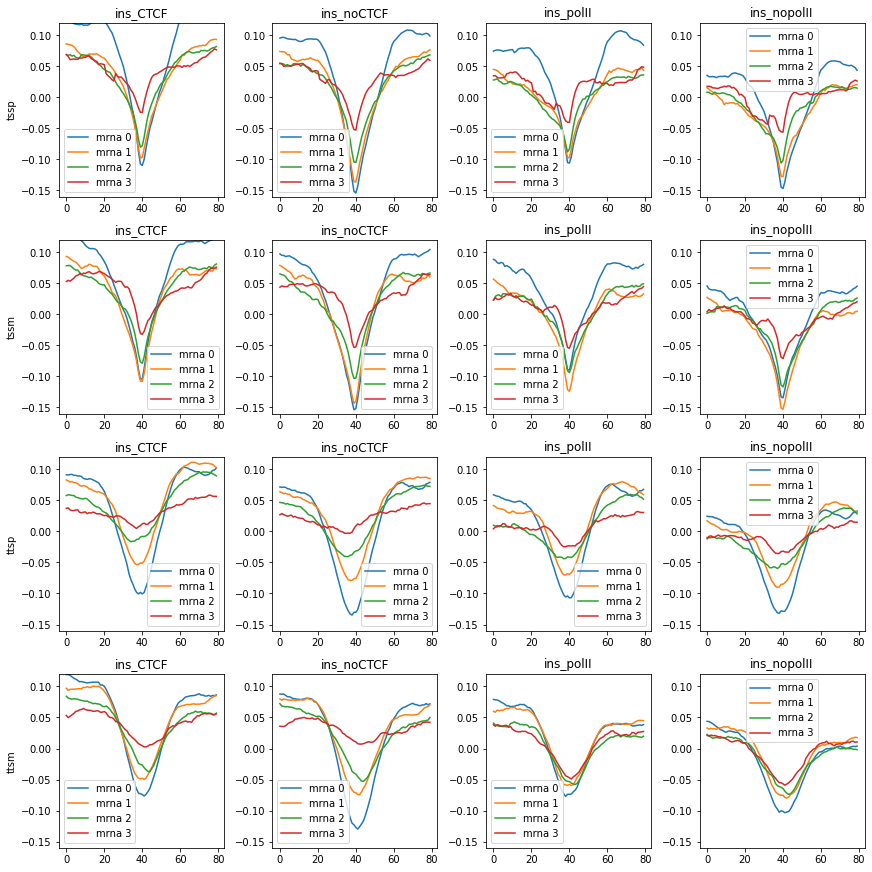

In [76]:
reordered_jdxs
ins_keys = [_ for _ in fig5_samples if _.startswith("ins")]


fig = plt.figure(figsize=(12,12),constrained_layout=True)
gs = fig.add_gridspec(4,4)

for fidx,feature_key in enumerate(flip_stackup_dict):
    the_stackups = flip_stackup_dict[feature_key]
    idxs = reordered_jdxs[feature_key]
    for i,kk in enumerate(ins_keys):
        ax = fig.add_subplot(gs[fidx,i])
        for level, a in enumerate(np.array_split(the_stackups[kk][idxs[300:]],4)):
            ax.plot(np.nanmean(a,axis=0),label=f"mrna {level}")
        ax.set_title(kk)
        if not i:
            ax.set_ylabel(feature_key)
        ax.set_ylim(-0.16,0.12)
        plt.legend()



#### plotting those running averages is integrated into `plot_stackups` function ...

In [16]:
dfs.keys()

odict_keys(['tssp', 'tssm', 'ttsp', 'ttsm'])

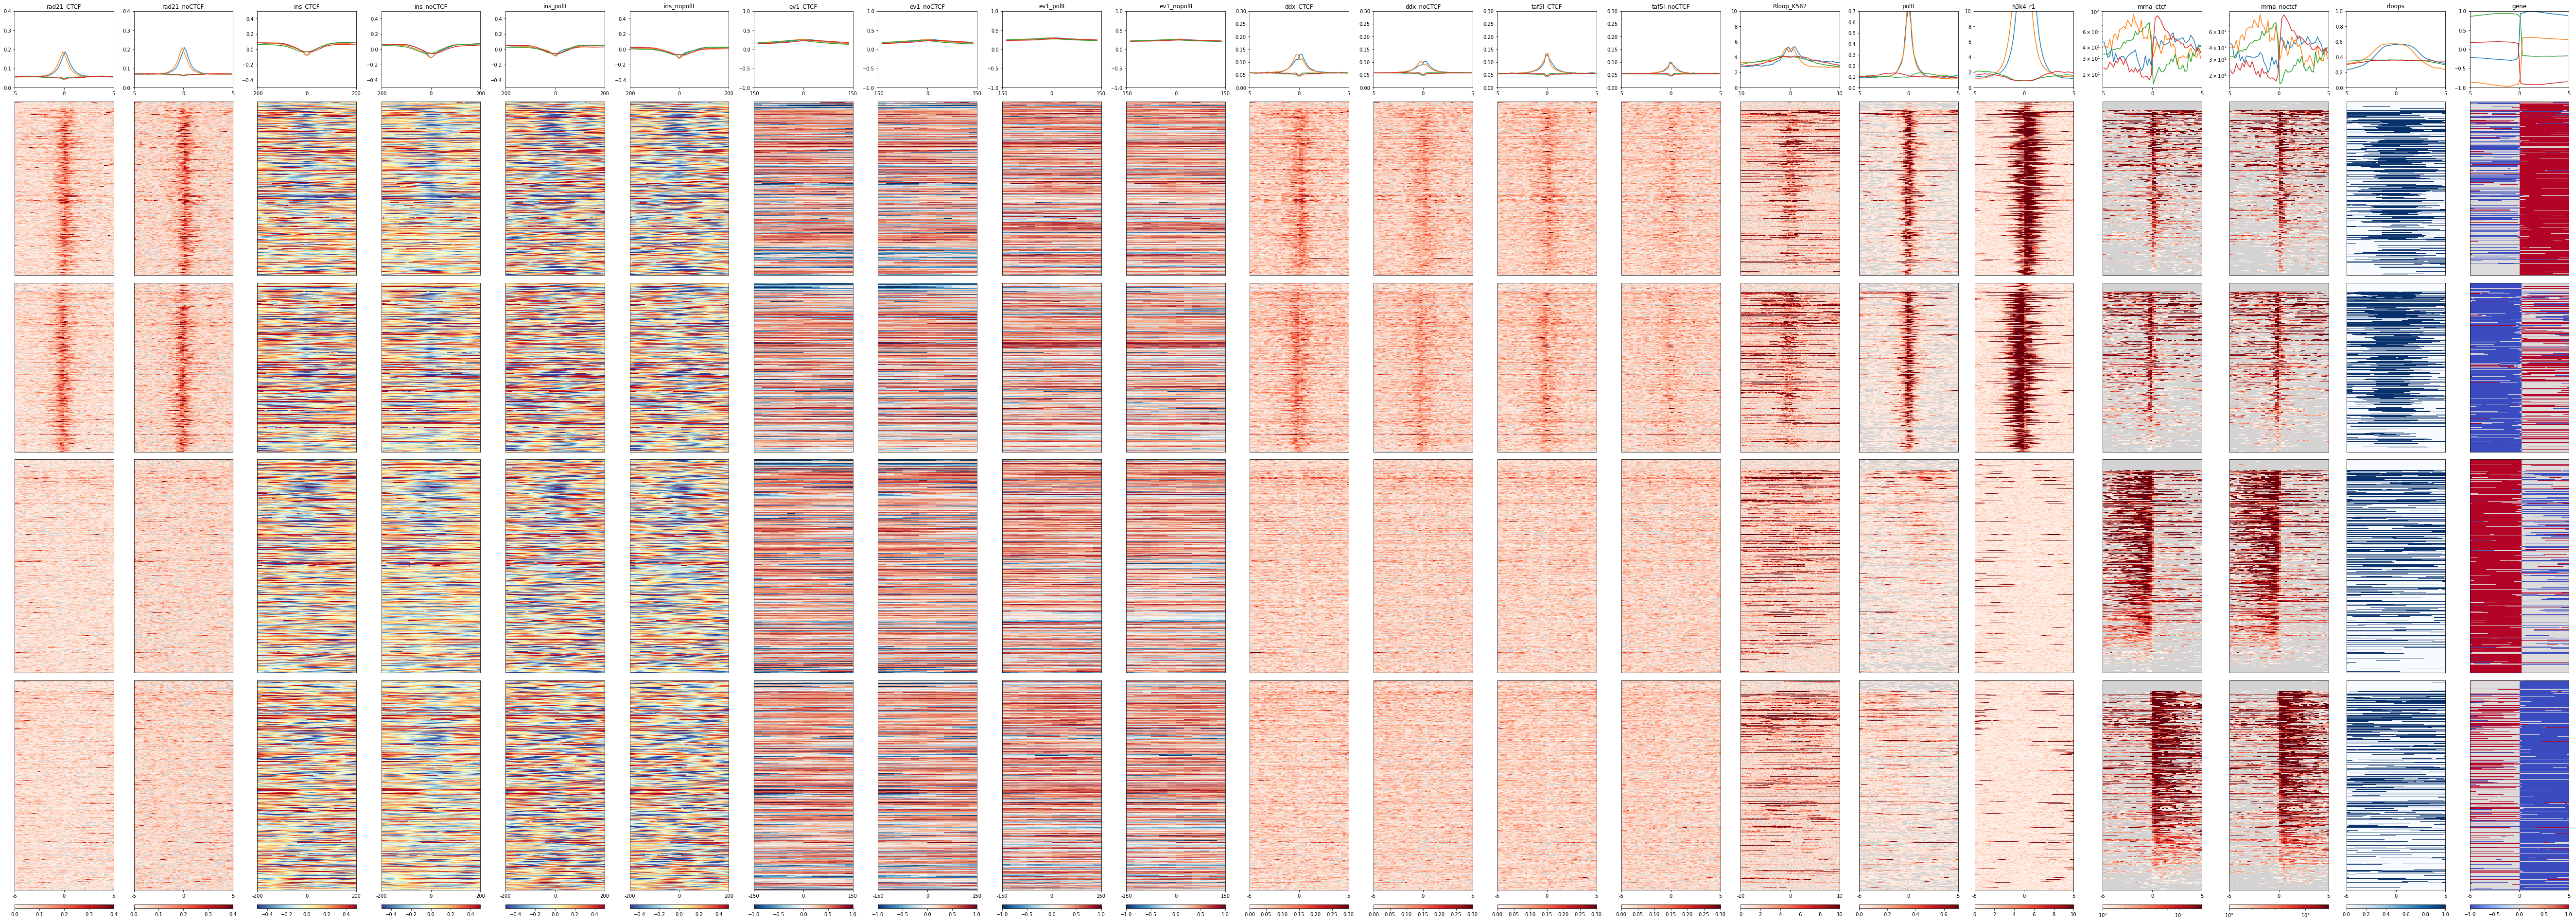

In [17]:
hmss = OrderedDict()

for feature_key in dfs.keys():
    jjj = reordered_jdxs[feature_key]
    _stackups = flip_stackup_dict[feature_key]
    hmss[feature_key] = [ _stackups[_k][jjj] for _k in fig5_samples ]

_limss = [ limss[_k] for _k in fig5_samples ]
_cmps = [ cmps[_k] for _k in fig5_samples ]
_binsizes = [ binsizes[_k] for _k in fig5_samples ]
_norms = [ norms[_k] for _k in fig5_samples ]

extra_order = None # [7,9]
hmss_order = None # [0,1,2,3,4,5,6,8]
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")
# xtra_axs - 2 dimensional list of axes, first index - "column"; second index is row - i.e. the stackup group

# plt.savefig("Fig5-Rloops-TSS-TTS.pdf")

(5750.0, 5800.0)

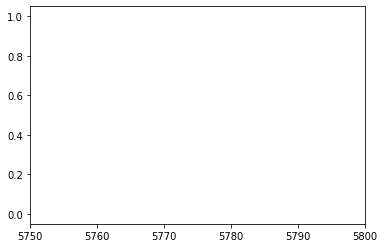

In [18]:
# NOW REORDER A STACKUPS FOR EACH FEATURE ACCORDING TO SOMETHING ....
for feature_key in flip_stackup_dict:
    the_stackups = flip_stackup_dict[feature_key]
    jjj = reordered_jdxs[feature_key]
    plt.plot(the_stackups['rloops_mean'][jjj])
    
ax = plt.gca()
ax.set_xlim(5750,5800)
# there are ~5770 of Rloop+ TSS and TTS -> let's select them !

In [19]:
hmss = OrderedDict()

for feature_key in feat_names.keys():
    iii = reordered_jdxs[feature_key][:5770]
    # sub-sorting on the fly ...
    tmp_stackups = { k:flip_stackup_dict[feature_key][k][iii].copy() for k in bw_fnames }
    # for a given aset of stackups for a given list of features ...
    _,width = tmp_stackups['ev1_polII'].shape
    center_bin = int(width/2)
    tmp_stackups['ev_mean'] = np.nanmean(tmp_stackups['ev1_polII'],axis=1)
#     tmp_stackups['ev_middle_drop'] = np.nanmean(tmp_stackups['ev1_CTCF'][:,1:center_bin],axis=1) - \
#                                 np.nanmean(tmp_stackups['ev1_CTCF'][:,-center_bin:-1],axis=1)
    tmp_stackups['mrna_mean'] = np.nanmean(tmp_stackups['mrna_ctcf'],axis=1)

    _sorting_key = 'mrna_mean'
    _, _iii = recursive_data_ordering(
        ks = [(_sorting_key, "sort", 1, False)],
        idxs = np.arange( len(tmp_stackups[_sorting_key]) ),
        data_dict = tmp_stackups,
        verbose=True
    )
    hmss[feature_key] = [ tmp_stackups[_k][_iii] for _k in fig5_samples ]

_limss = [ limss[_k] for _k in fig5_samples ]
_cmps = [ cmps[_k] for _k in fig5_samples ]
_binsizes = [ binsizes[_k] for _k in fig5_samples ]
_norms = [ norms[_k] for _k in fig5_samples ]

extra_order = None # [7,9]
hmss_order = None # [0,1,2,3,4,5,6,8]
print("ready to plot ...")
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")

# plt.savefig("Fig5-Rloops-STRONG-TSS-TTS.pdf")

KeyError: 'tss'

In [ ]:
hmss = OrderedDict()

for feature_key in feat_names.keys():
    iii = reordered_jdxs[feature_key][:5770]
    # sub-sorting on the fly ...
    tmp_stackups = { k:flip_stackup_dict[feature_key][k][iii].copy() for k in bw_fnames }
    # for a given aset of stackups for a given list of features ...
    _,width = tmp_stackups['gene'].shape
    center_bin = int(width/2)
    tmp_stackups['mean_gene'] = np.nanmean(tmp_stackups['gene'][:,:],axis=1)
    #
    _sorting_key = 'mean_gene'
    _, _iii = recursive_data_ordering(
        ks = [(_sorting_key, "sort", 1, False)],
        idxs = np.arange( len(tmp_stackups[_sorting_key]) ),
        data_dict = tmp_stackups,
        verbose=True
    )
    hmss[feature_key] = [ tmp_stackups[_k][_iii] for _k in fig5_samples ]

_limss = [ limss[_k] for _k in fig5_samples ]
_cmps = [ cmps[_k] for _k in fig5_samples ]
_binsizes = [ binsizes[_k] for _k in fig5_samples ]
_norms = [ norms[_k] for _k in fig5_samples ]

extra_order = None # [7,9]
hmss_order = None # [0,1,2,3,4,5,6,8]
print("ready to plot ...")
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")

# plt.savefig("Fig5-Rloops-STRONG-TSS-TTS.pdf")

In [ ]:
# # save strong R-loop TSS and TTS to separate BED-files for future use ...
# for feature_key in feat_names.keys():
#     lll = reordered_jdxs[feature_key][:5770]
#     # sub-sorting on the fly ...
#     # display(dfs[feature_key].iloc[np.sort(lll)])
#     dfs[feature_key].iloc[np.sort(lll)].to_csv(
#         f"{feature_key}-rloops-strong.bed",
#         sep="\t",
#         header=None,
#         index=False
#     )


In [ ]:
# xxxx = bioframe.read_table("hg19_arms.bed",schema="bed3",index_col=False)
# xxxx.to_csv("xxxx.bed",sep="\t",header=True,index=False)
# ! head xxxx.bed

In [ ]:
# # check what we have here locally ...
# ! ls Fig2*pdf
# ! ssh ghpcc ls /nl/umw_job_dekker/users/sv49w/ALV2021
# ! scp Fig2* ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp masterlist*.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp Fig4-ddf-taf.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# ! scp Fig5-*.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

# !wc -l *-rloops-strong.bed
# ! scp *-rloops-strong.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/